In [86]:
import pandas as pd

In [141]:
import pickle

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [88]:
# our business goal is to get trips less then 1 hour, so we create a new target variable duration and express it in minutes
def read_dataframe(filename):
    
    df = pd.read_parquet(filename)
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # we can check the distribution of the trip duration to check whats happening
    # sns.distplot(df.duration)
    
    # we are creating a subset of more relevant trips (the ones between 1 and 60 minutes)
    df = df[((df.duration >= 1) & (df.duration <= 60))]
   
    # we can also check for some stats of the variable
    # df.duration.describe()
    
    # feature selection - selecting the collumns that we can extract information and use them on the model
    # despite the locations being a number, we treat it as it were categorical because it represent a location and we want to benefit from one-hot encoding
    categorical = ['PULocationID', 'DOLocationID']
    
    # one hot encoding for the variables. as we are already have our categorical variables as int, we just need to cast them to strings
    df[categorical] = df[categorical].astype(str)
    
    return df

In [89]:
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [90]:
len(df_train), len(df_val)

(73908, 61921)

In [132]:
# we can create a new feature that combines pickup and dropoff
# it's a interaction feature
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [133]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,2,2021-02-28 22:19:00,2021-02-28 22:29:00,None,NaN,129,7,NaN,2.63,10.04,...,0.00,0.0,None,0.3,10.34,NaN,NaN,NaN,10.000000,129_7
64568,2,2021-02-28 23:18:00,2021-02-28 23:27:00,None,NaN,116,166,NaN,1.87,8.33,...,1.89,0.0,None,0.3,10.52,NaN,NaN,NaN,9.000000,116_166
64569,2,2021-02-28 23:44:00,2021-02-28 23:58:00,None,NaN,74,151,NaN,2.40,12.61,...,0.00,0.0,None,0.3,12.91,NaN,NaN,NaN,14.000000,74_151
64570,2,2021-02-28 23:07:00,2021-02-28 23:14:00,None,NaN,42,42,NaN,1.11,11.95,...,0.00,0.0,None,0.3,15.00,NaN,NaN,NaN,7.000000,42_42


In [134]:
categorical = ['PU_DO']
numerical = ['trip_distance']

# to use a dict vectorizer (transforms a dictionary into a vector) we must transform the features we want to use in dictionaires
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [121]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [135]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715212021978

In [143]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out)

C:\Users\jobea\AppData\Local\Temp\ipykernel_13772\2408696693.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="predictions")
C:\Users\jobea\AppData\Local\Temp\ipykernel_13772\2408696693.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="actual")


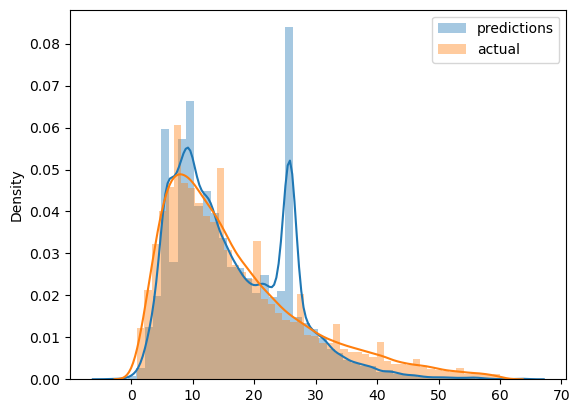

In [136]:
sns.distplot(y_pred, label="predictions")
sns.distplot(y_train, label="actual")

plt.legend()

In [140]:
l = Lasso(alpha=0.001)
l.fit(X_train, y_train)

y_pred = l.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False) # our model is wrong, on avg, by 9 minutes. let's say this is our baseline

9.233436225720547

In [138]:
r = Ridge(alpha=0.001)
r.fit(X_train, y_train)

y_pred = r.predict(X_val)


mean_squared_error(y_val, y_pred, squared=False) # our model is wrong, on avg, by 9 minutes. let's say this is our baseline

11.342565604820129